In [1]:
import numpy as np
from scipy import ndimage
import tensorflow as tf
from os import listdir

#has package pillow as a dependency. Is needed to give scipy image operations. 
from scipy import misc
import scipy

from modules.utils import *
from modules.model import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''Constants'''
IMAGE_FOLDER = "data/anime wallpapers"

BATCH_SIZE = 1
SCALE = 2
EPOCHS = 35

INPUT_SIZE = Dimensions(1080//2, 1920//2)
OUTPUT_SIZE = Dimensions(INPUT_SIZE.h*SCALE, INPUT_SIZE.w*SCALE)

LEARNING_RATE = 0.001

In [3]:
'''Load data'''
image_png_names = listdir(IMAGE_FOLDER + "/png")
image_jpg_names = listdir(IMAGE_FOLDER + "/jpg")
num_pngs = len(image_png_names)
num_jpgs = len(image_jpg_names)
image_png_paths = [IMAGE_FOLDER + '/png/' + name for name in image_png_names]
image_jpg_paths = [IMAGE_FOLDER + '/jpg/' + name for name in image_jpg_names]

In [4]:
def upscaler(in_tensor, in_channels, f_1, f_r, f_u, out_channels):
    upscale_model = Model("Upscaler", in_tensor)
    upscale_model.full_conv2d(3,f_1)
    upscale_model.relu()

    upscale_model.add_residual_block(f_1,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)


    '''
    upscale_model.upscale([OUTPUT_SIZE.h//2,OUTPUT_SIZE.w//2])
    upscale_model.full_conv2d(f_r,f_u, mapsize=3)
    upscale_model.relu()
    '''
    
    upscale_model.upscale([OUTPUT_SIZE.h,OUTPUT_SIZE.w])
    upscale_model.full_conv2d(f_u,f_u, mapsize=3)
    upscale_model.relu()
    
    upscale_model.full_conv2d(f_u, 3, mapsize=1)
    upscale_model.rgb_bound()
    upscale_model.reshape([-1,OUTPUT_SIZE.h*OUTPUT_SIZE.w*3])
    return upscale_model

In [5]:
small_train = tf.placeholder('float32', shape = [None, INPUT_SIZE.h, INPUT_SIZE.w, 3])
large_train = tf.placeholder('float32', shape = [None, OUTPUT_SIZE.h, OUTPUT_SIZE.w, 3])
small_train_flattened = tf.reshape(small_train,[-1, INPUT_SIZE.h*INPUT_SIZE.w*3])
large_train_flattened = tf.reshape(large_train,[-1, OUTPUT_SIZE.h*OUTPUT_SIZE.w*3])


upscale_model = upscaler(small_train, 3, 64, 64, 64, 3)

up_MSE = tf.reduce_mean(tf.square(upscale_model.get_output() - large_train_flattened))
up_loss = up_MSE
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(up_loss,var_list=upscale_model.variables)
pred = tf.reshape(tf.cast(upscale_model.get_output(), dtype=tf.uint8),[-1,OUTPUT_SIZE.h, OUTPUT_SIZE.w, 3])

init = tf.initialize_all_variables()

In [6]:
image_gen = minibatch_image_generator(image_png_paths[0:1200],BATCH_SIZE)

In [6]:
sess = tf.Session()
sess.run(init)

In [8]:
print("generating images")
epoch,image_batch = next(image_gen)
in_image = np.array([scipy.misc.imresize(img,[INPUT_SIZE.h,INPUT_SIZE.w], interp='bicubic') for img in image_batch])
out_image = np.array([scipy.misc.imresize(img,[OUTPUT_SIZE.h,OUTPUT_SIZE.w], interp='bicubic') for img in image_batch])
print("generated images") 

generating images
generated images


In [9]:
len(image_png_paths)

1225

In [11]:
try:
    index = 0
    epoch = 0
    while epoch < 25:
        index += 1
        (_) = sess.run([optimizer], feed_dict={small_train:in_image, large_train:out_image})
        epoch,image_batch = next(image_gen)
        in_image = np.array([scipy.misc.imresize(img, [INPUT_SIZE.h, INPUT_SIZE.w]) for img in image_batch])
        out_image = np.array([scipy.misc.imresize(img, [OUTPUT_SIZE.h, OUTPUT_SIZE.w]) for img in image_batch])
        if(index % 1200 == 0):
            (mse) = sess.run(up_loss, feed_dict={small_train:in_image, large_train:out_image})
            print('epoch = %-5d step = %-5d mse = %-10f' % (epoch, index, mse))

    (sample) = sess.run(pred,feed_dict={small_train:in_image, large_train:out_image})
except KeyboardInterrupt:
    pass #avoids getting KeyboardInterrupt errors when stopping training early
except:
    raise

epoch = 1     step = 1200  mse = 16.071951 
epoch = 2     step = 2400  mse = 12.742133 
epoch = 3     step = 3600  mse = 13.326418 
epoch = 4     step = 4800  mse = 11.740159 
epoch = 5     step = 6000  mse = 10.587519 
epoch = 6     step = 7200  mse = 10.848311 
epoch = 7     step = 8400  mse = 9.210980  
epoch = 8     step = 9600  mse = 8.462211  
epoch = 9     step = 10800 mse = 7.982008  
epoch = 10    step = 12000 mse = 7.729213  
epoch = 11    step = 13200 mse = 7.221084  
epoch = 12    step = 14400 mse = 6.962748  
epoch = 13    step = 15600 mse = 6.740884  
epoch = 14    step = 16800 mse = 6.349706  
epoch = 15    step = 18000 mse = 6.536185  
epoch = 16    step = 19200 mse = 6.642328  
epoch = 17    step = 20400 mse = 7.391597  
epoch = 18    step = 21600 mse = 6.181310  
epoch = 19    step = 22800 mse = 6.226988  
epoch = 20    step = 24000 mse = 5.874210  
epoch = 21    step = 25200 mse = 6.026606  
epoch = 22    step = 26400 mse = 5.699905  
epoch = 23    step = 27600 mse =

In [10]:
out_gen = minibatch_image_generator(image_png_paths[1203:1204],BATCH_SIZE)

_,test_batch = next(out_gen)
in_image_t = np.array([scipy.misc.imresize(img,[INPUT_SIZE.h,INPUT_SIZE.w], interp='bicubic') for img in test_batch])
out_image_t = np.array([scipy.misc.imresize(img,[OUTPUT_SIZE.h,OUTPUT_SIZE.w], interp='bicubic') for img in test_batch])

In [11]:
(sample) = sess.run(pred,feed_dict={small_train:in_image_t})

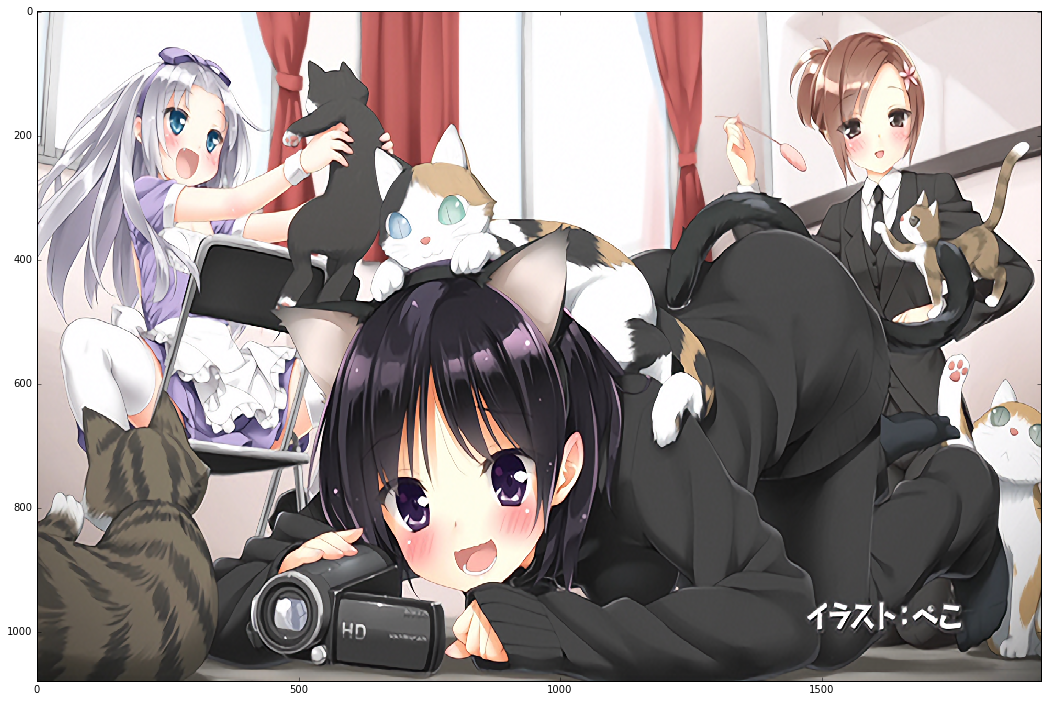

In [12]:
plt.figure(figsize = (18,12))
plt.imshow(sample[0],interpolation='nearest', aspect='auto')

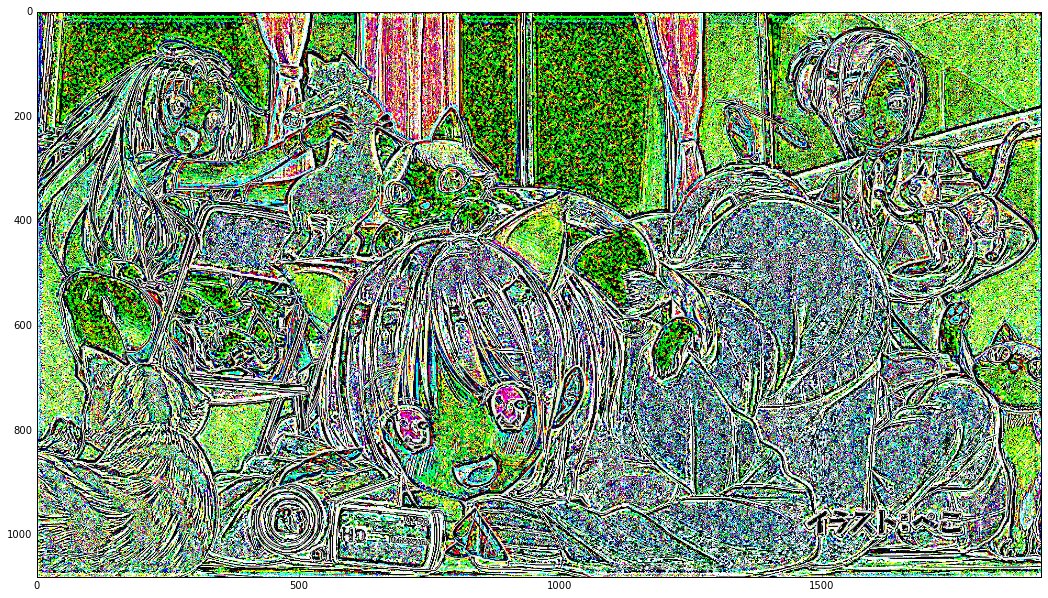

In [13]:
plt.figure(figsize = (18,12))
shape = sample[0].shape
diff_flat = abs(np.reshape(sample[0]-out_image_t[0],[-1]))
diff = np.reshape(diff_flat,shape)
plt.imshow(diff)

In [ ]:
flat = np.reshape(out_image_t[0],[-1])
min(flat)

In [35]:
output_number = 32
rezoomed = misc.imresize(in_image[0],[OUTPUT_SIZE.h, OUTPUT_SIZE.w])
#output_number = output_number + 1
misc.imsave("data/anime wallpapers/generated_output/"+str(output_number)+"_output.png", sample[0])
misc.imsave("data/anime wallpapers/generated_output/"+str(output_number)+"_input.png", in_image_t[0])
misc.imsave("data/anime wallpapers/generated_output/"+str(output_number)+"_original.png", out_image_t[0])
misc.imsave("data/anime wallpapers/generated_output/"+str(output_number)+"_diff.png", sample[0]-out_image_t[0])
print("Created images with number = "+str(output_number))

Created images with number = 32


In [7]:
saver = tf.train.Saver(upscale_model.variables)

In [22]:
saver.save(sess, 'saves/s', global_step=1)

'saves/s-1'

In [8]:
saver.restore(sess,'saves/saves-1')

NotFoundError: Tensor name "Upscaler_L001/weight" not found in checkpoint files saves/saves-1
	 [[Node: save/restore_slice = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/restore_slice/tensor_name, save/restore_slice/shape_and_slice)]]
	 [[Node: save/restore_slice_7/_45 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_173_save/restore_slice_7", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
Caused by op 'save/restore_slice', defined at:
  File "/home/peter/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/peter/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/peter/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/peter/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/home/peter/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/peter/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/peter/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-056b3e702916>", line 1, in <module>
    saver = tf.train.Saver(upscale_model.variables)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 986, in __init__
    self.build()
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1015, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 620, in build
    restore_sequentially, reshape)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 357, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 270, in restore_op
    preferred_shard=preferred_shard))
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/io_ops.py", line 204, in _restore_slice
    preferred_shard, name=name)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 359, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2372, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/peter/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()


In [13]:
#Clears everything
sess.close()
tf.reset_default_graph()